In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.plotsiii import plotiii1, plotiii2
from src.plotsv import plotv1, plotv2

### Tensorflow HMC 

In [2]:
from corner import corner
import tensorflow as tf
import tensorflow_probability as tfp

tdf = tfp.distributions

In [3]:
# set seed
np.random.seed(120420)
tf.random.set_seed(120420)

# read text file
file_path = 'src/lighthouse_flash_data.txt'

# Read the data
def read_data(file_path):
    '''
    Function to read data from a text file and return it as two lists.
    '''
    # initialise lists to store the data
    column1 = []  
    column2 = []  
    
    with open(file_path, 'r') as file:  # Open the file for reading
        for line in file:  # Iterate over each line in the file
            parts = line.split()  # Split the line by whitespace
            
            # Append the parts to their respective column lists
            column1.append(float(parts[0]))
            column2.append(float(parts[1]))

    return column1, column2


In [4]:
# observed flashes
x_observed = np.array(read_data(file_path)[0], dtype=np.float32)

# constants for the uniform prior
a = -3
b = 2 # 2
c = 0.5
d = 5


# joint log probability function
def joint_log_prob(x, alpha, beta):
    # likelihood
    likelihood = tdf.Cauchy(loc=alpha, scale=beta).log_prob(x)
    log_likelihood = tf.reduce_sum(likelihood)

    # prior
    log_prior_alpha = tf.where(
        tf.logical_and(alpha > a, alpha < b),
        tf.math.log(1/(b-a)),
        -np.inf
    
    )
    log_prior_beta = tf.where(
        tf.logical_and(beta > c, beta < d),
        tf.math.log(1/(d-c)),
        -np.inf
    )

    return log_prior_alpha + log_prior_beta + log_likelihood

# Define the unnormalized posterior (target distribution)
def unnormalized_posterior(alpha, beta):            
    return joint_log_prob(x_observed, alpha, beta)


In [5]:
# nuts kernel
nuts_kernel = tfp.mcmc.NoUTurnSampler(
    target_log_prob_fn=unnormalized_posterior,
    step_size=np.float64(.5) #0.08
)

num_burnin_steps = 300 #100
# Adpative step size
num_adaptation_steps = int(num_burnin_steps * 0.9)
adaptive_nuts = tfp.mcmc.SimpleStepSizeAdaptation(
  nuts_kernel,
  num_adaptation_steps=int(num_adaptation_steps),
  target_accept_prob=np.float64(0.65))  # 0.75


# run hmc
@tf.function
def run_chain(initial_state, num_results=10000, num_burnin_steps=num_burnin_steps): # 30000, 300
  samples, kernel_results = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=adaptive_nuts,
      trace_fn=lambda current_state, kernel_results: kernel_results)
  return samples, kernel_results

# Number of chains and initial values
num_chains = 8

initial_alpha = tf.random.uniform([num_chains, 1], minval=a, maxval=b)  # Shape [num_chains, 1]
initial_beta = tf.random.uniform([num_chains, 1], minval=c, maxval=d)  # Shape [num_chains, 1]

# Combine initial states
initial_state = [initial_alpha, initial_beta]

# Run the chains
samples, kernel_results = run_chain(initial_state=initial_state)
alpha_samples, beta_samples = samples


/Users/maxtalberg/miniconda3/envs/S2-env/lib/python3.8/site-packages/tensorflow_probability/python/__init__.py:74: UserWarning: TensorFloat-32 matmul/conv are enabled for NVIDIA Ampere+ GPUs. The resulting loss of precision may hinder MCMC convergence. To turn off, run `tf.config.experimental.enable_tensor_float_32_execution(False)`. For more detail, see https://github.com/tensorflow/community/pull/287.
  warnings.warn(
2024-03-09 19:57:04.072253: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [ ]:
import tensorflow as tf

# Assuming alpha_samples and beta_samples are defined and have the shape (50000, 8, 1)
combined_samples = tf.concat([alpha_samples, beta_samples], axis=-1)
combined_samples

from zeus import AutoCorrTime

taus = AutoCorrTime(np.array(combined_samples))
print('Autocorrelation:', taus)

tau = max(taus)
print(f"{tau = }")


Autocorrelation: [16.85709763 49.39247894]
tau = 49.392478942871094


In [ ]:
ess = tfp.mcmc.effective_sample_size(combined_samples)

# `ess` will be a Tensor of the same shape as a single sample (the '...' part),
# containing the ESS for each parameter (or dimension of the sample space).

# To evaluate and print the ESS values, you might need to convert them to numpy arrays
# if you're not using eager execution in TensorFlow
ess_numpy = ess.numpy()
print("Effective Sample Size:\n", ess_numpy)

aggregated_ess = tf.reduce_sum(ess, axis=0)

# `aggregated_ess` will now be a 1D tensor with the aggregated ESS for each parameter
print("Aggregated Effective Sample Size for each parameter:\n", aggregated_ess.numpy())

Effective Sample Size:
 [[ 357.46335  100.05067]
 [ 508.5573   974.0449 ]
 [1105.9482   432.9052 ]
 [ 459.8327   175.35257]
 [ 872.46893  195.5797 ]
 [ 584.0129   275.77145]
 [ 966.102    390.03622]
 [ 798.4307   520.1024 ]]
Aggregated Effective Sample Size for each parameter:
 [5652.816  3063.8428]


In [ ]:
# Assuming alpha_samples and beta_samples are your MCMC outputs
# First, remove the unnecessary middle dimension (which is 1 in your case)
alpha_flat = alpha_samples.numpy().squeeze()  # This changes shape from (300, 1, 1) to (300,)
beta_flat = beta_samples.numpy().squeeze()  # Same here

# Stack alpha and beta samples along a new axis to get the correct shape
samples_np = np.stack([alpha_flat, beta_flat], axis=-1)  # This should give you a shape of (300, 2)

# mean and std of alpha and beta
mean_alpha = np.mean(alpha_samples)
std_alpha = np.std(alpha_samples)

mean_beta = np.mean(beta_samples)
std_beta = np.std(beta_samples)

print('alpha:', mean_alpha, std_alpha)
print('beta:', mean_beta, std_beta)

alpha: -0.49756646 0.3607785
beta: 1.7332836 0.39284736


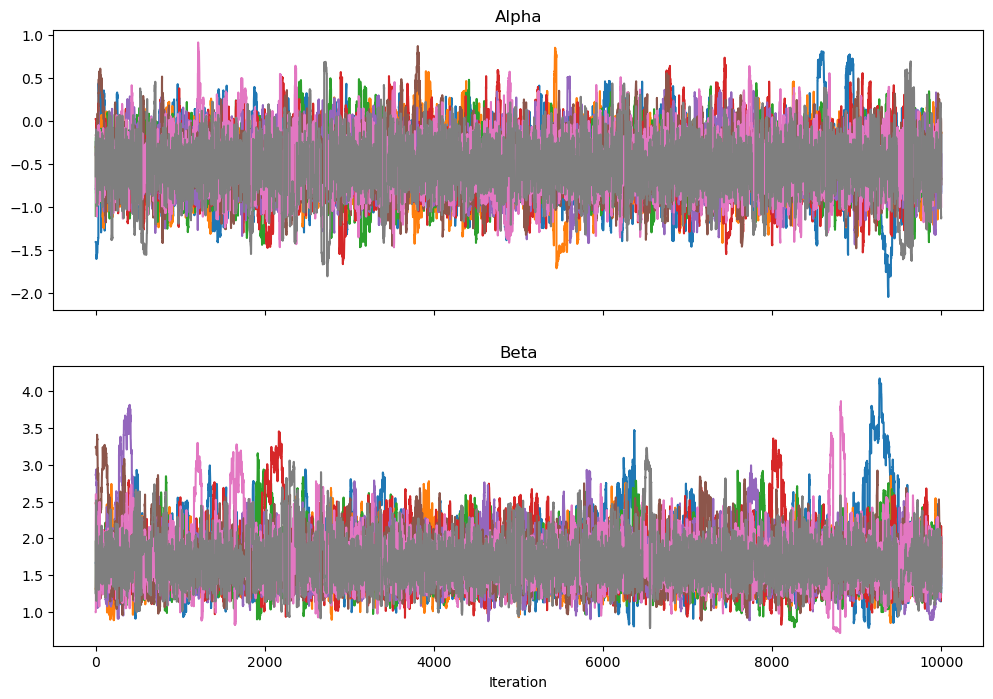

In [ ]:
# plot alpha and beta samples
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 8))
axes[0].plot(alpha_flat)
axes[0].title.set_text('Alpha')
axes[1].plot(beta_flat)
axes[1].title.set_text('Beta')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('')


plt.show()


/Users/maxtalberg/miniconda3/envs/S2-env/lib/python3.8/site-packages/arviz/data/base.py:169: UserWarning: More chains (10000) than draws (8). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


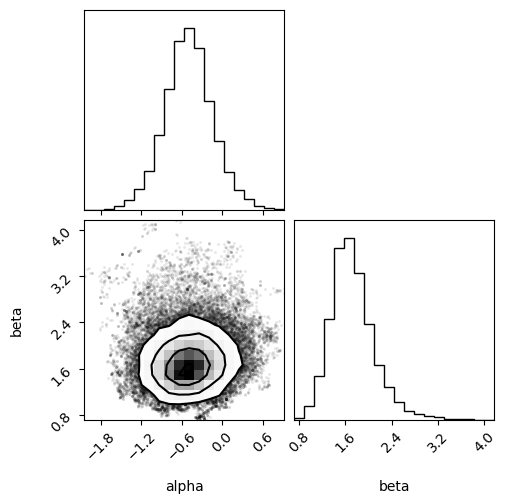

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import corner


# Now, use the corner plot
corner.corner(samples_np, labels=['alpha', 'beta'])
plt.show()


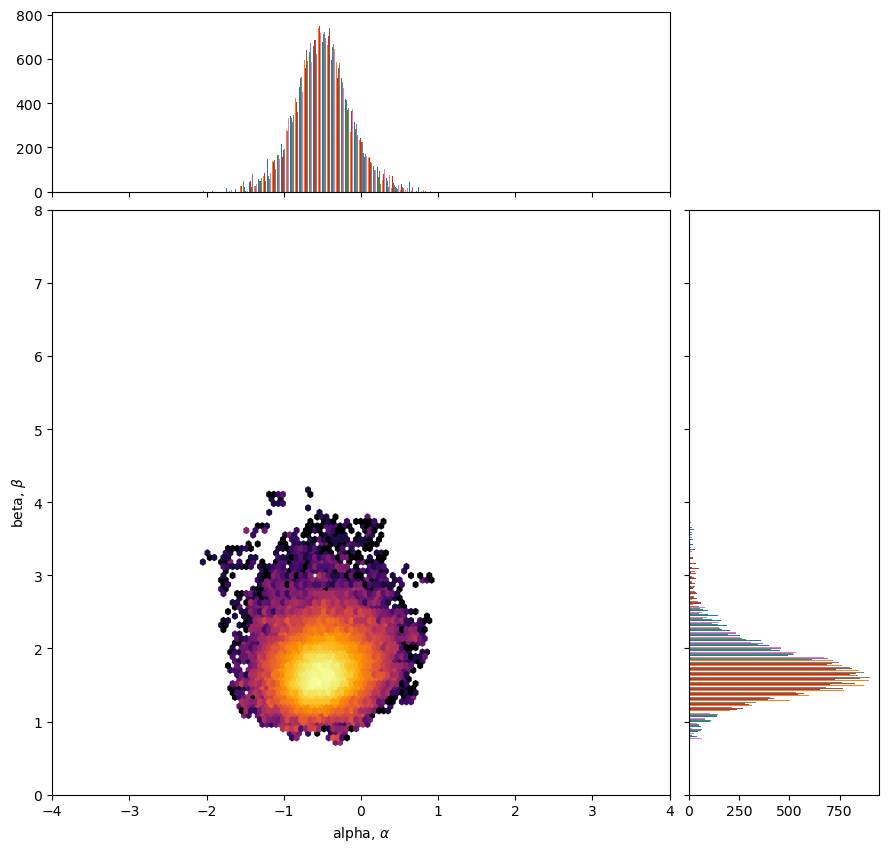

In [ ]:
samples_flat = alpha_flat, beta_flat
xrange = a, b
yrange = c, d
plotv1(samples_flat, xrange, yrange)

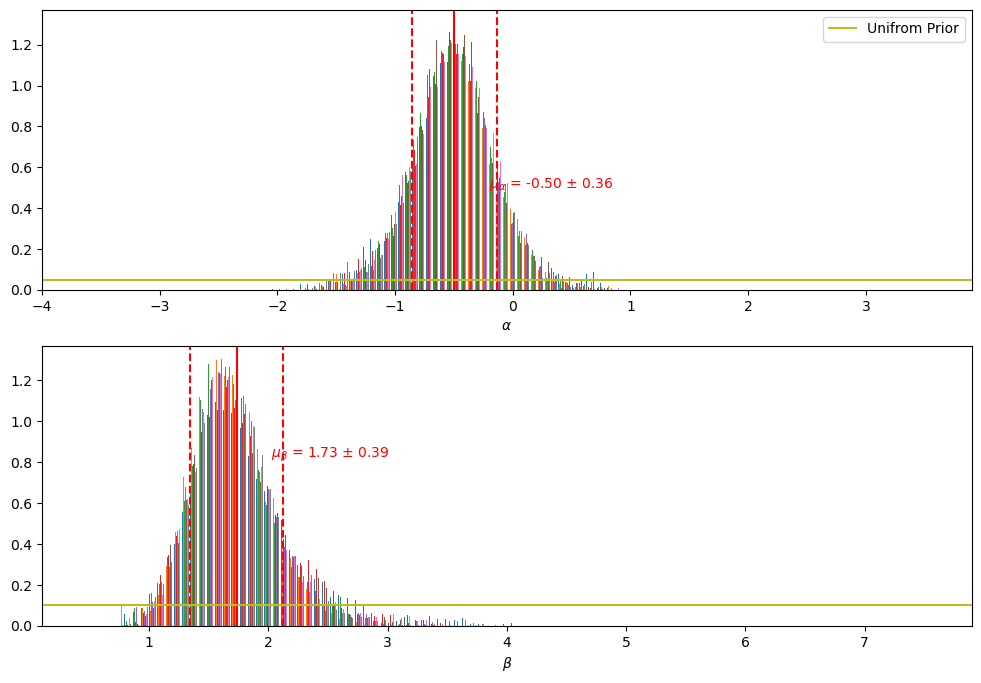

In [ ]:
plotv2(samples_flat, xrange, yrange)

In [13]:
hmc_kernel_results = kernel_results.inner_results


r_hat = tfp.mcmc.potential_scale_reduction(samples)
print("Acceptance rate:", hmc_kernel_results.is_accepted.numpy().mean())
r_hat_numpy = [tensor.numpy() for tensor in r_hat]

# Now you can print the r_hat values
print("R-hat diagnostic (per latent variable):", r_hat_numpy)


Acceptance rate: 0.8846
R-hat diagnostic (per latent variable): [array([1.0024086], dtype=float32), array([1.009959], dtype=float32)]
